In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt, operator as op
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from warnings import simplefilter
from sklearn.base import BaseEstimator, TransformerMixin
simplefilter("ignore", category=RuntimeWarning)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from datetime import datetime
from prettytable import PrettyTable

In [4]:
# Strategic imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Machine learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier

# imports to mute warnings
pd.options.display.max_rows=200
pd.set_option('mode.chained_assignment', None)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=RuntimeWarning)

DOWNLOAD TRAINING AND TEST SET


In [11]:
# DOWNLOAD DATA INTO DATAFRAME
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_labels = pd.read_csv('labels.csv')
labels= pd.DataFrame(data=train['Survived'])
df_submissions = pd.read_csv('gender_submission.csv')

In [12]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [13]:
# SIZE
print('The Training set contains',len(train), 'observations')
print('The Test set contains',len(test), 'observations')


The Training set contains 891 observations
The Test set contains 418 observations


In [14]:
# check NaN Values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Let's create

- Ticket Frequency. Apparently Ticket feauture has no only unique values. Therefore the values belong to a group ticket
- Fare Individual
- Title
- Cabin and Cabin_assembled 

In [16]:
df_train =train.copy()
df_test = test.copy()


# Ticket_frequency and Fare_individual
df_train['Ticket_frequency'] = df_train.Ticket.map(df_train.Ticket.value_counts())
df_train['Fare_individual']= df_train['Fare'] / df_train['Ticket_frequency']

df_test['Ticket_frequency'] = df_test.Ticket.map(df_test.Ticket.value_counts())
df_test['Fare_individual']= df_test['Fare'] / df_test['Ticket_frequency']

df_full = pd.concat([df_train,df_test]).reset_index(drop=True)



# TITLE
def Create_Title(df_full):
    
    df_full['Title']= np.nan
    df_full['Title'] = df_full.Name.str.extract(pat='([a-zA-Z]+\.)')
    print(df_full.Title.unique())

    
    for i in range(len(df_full)):
        if df_full['Title'][i] == 'Don.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Mme.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Ms.':
            df_full.Title[i] = 'Miss.'
        elif df_full.Title[i] == 'Major.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Lady.':
            df_full.Title[i] = 'Miss.'
        elif df_full.Title[i] == 'Sir.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Mlle.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Col.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Capt.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Countess.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Jonkheer.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Dona.':
            df_full.Title[i] = 'Mrs.'
        
    print(df_full.Title.unique())
    return df_full

# CABIN
def create_feature_Cabin(df_full):
    df_full['Cabin'] = df_full['Cabin'].astype(str).str[0]
    df_full = df_full.replace({'Cabin': 'n'}, {'Cabin': 'missing'}, regex=True)
    df_full['Cabin_Assembled'] = df_full['Cabin']
    df_full = df_full.replace({'Cabin_Assembled' : {'B': 'BC', 'C': 'BC', 'D': 'DE', 'E':'DE', 'F': 'FG', 'G':'FG', 'T':'A'}})

    
    return df_full

# TICKET
def Ticket_code(df_train):
    
    df_training = df_train.copy()
    for i in range(len(df_training)):

        if df_training['Ticket'][i][:5]=='A./5.':
            df_training['Ticket'][i] = 'A5'

        elif df_training['Ticket'][i][:8]=='S.C./A.4.':
            df_training['Ticket'][i] = 'SC/A4'

        elif df_training['Ticket'][i][:4]=='S.P.':
            df_training['Ticket'][i] = 'SP'

        elif df_training['Ticket'][i][:4]=='A.5.':
            df_training['Ticket'][i] = 'A5'

        elif df_training['Ticket'][i][:3]=='A/S':
            df_training['Ticket'][i] = 'A5'

        elif df_training['Ticket'][i][:2]=='CA':
            df_training['Ticket'][i] = 'CA'

        elif df_training['Ticket'][i][:6]=='S.O.C.':
            df_training['Ticket'][i] = 'SOC'

        elif df_training['Ticket'][i][:4]=='SO/C':
            df_training['Ticket'][i] = 'SO/C'

        elif df_training['Ticket'][i][:3]=='A4.':
            df_training['Ticket'][i] = 'A4'

        elif df_training['Ticket'][i][:4]=='LINE':
            df_training['Ticket'][i] = 'Line'

        elif df_training['Ticket'][i][:2]=='PP':
            df_training['Ticket'][i] = 'PP'

        elif df_training['Ticket'][i][:6]=='F.C.C.':
            df_training['Ticket'][i] = 'FCC'

        elif df_training['Ticket'][i][:3]=='W/C':
            df_training['Ticket'][i] = 'WC'

        elif df_training['Ticket'][i][:3]=='SW/PP':
            df_training['Ticket'][i] = 'SW/PP'

        elif df_training['Ticket'][i][:3]=='CA':
            df_training['Ticket'][i] = 'CA'

        elif len(df_training['Ticket'][i])==6 and df_training['Ticket'][i][0]=='3':
            
            #select_ticket_3.append(i)
            df_training['Ticket'][i] = '300'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][0]=='5':
            #select_ticket_3.append(i)
            df_training['Ticket'][i] = '50'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][0]=='6':
            #select_ticket_3.append(i)
            df_training['Ticket'][i] = '60'


        elif len(df_training['Ticket'][i])==6 and df_training['Ticket'][i][0]=='3':
            #select_ticket_3.append(i)
            df_training['Ticket'][i] = '300'


        elif len(df_training['Ticket'][i])==7 and df_training['Ticket'][i][0]=='3':
            df_training['Ticket'][i] = '3000'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='1':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='2':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='3':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='4':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='5':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='6':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='8':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='9':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==3 and df_training['Ticket'][i][0]=='6':
            df_training['Ticket'][i] = '999'


        elif len(df_training['Ticket'][i])==4 and df_training['Ticket'][i][0]=='7':
            df_training['Ticket'][i] = '9999'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][:2]=='14':
            df_training['Ticket'][i] = '10'

        elif df_training['Ticket'][i][:3]=='A/5':
            df_training['Ticket'][i] = 'A5'

        elif df_training['Ticket'][i][:3]=='A/4':
            df_training['Ticket'][i] = 'A4'

        elif df_training['Ticket'][i][:2]=='CA.':
            df_training['Ticket'][i] = 'CA'

        elif df_training['Ticket'][i][:2]=='SP':
            df_training['Ticket'][i] = 'SP'

        elif df_training['Ticket'][i][:5]=='W./C.':
            df_training['Ticket'][i] = 'WC'

        elif df_training['Ticket'][i][:5]=='SOTON':
            df_training['Ticket'][i] = 'SOT'

        elif df_training['Ticket'][i][0]=='C':
            df_training['Ticket'][i] = 'C'

        elif df_training['Ticket'][i][:4]=='STON':
            df_training['Ticket'][i] = 'STON'

        elif df_training['Ticket'][i][:2]=='PC':
            df_training['Ticket'][i] = 'PC'

        elif len(df_training['Ticket'][i])==6 and df_training['Ticket'][i][:1]=='1':
            df_training['Ticket'][i] = '100'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][:1]=='3':
            df_training['Ticket'][i] = '30'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][:1]=='1':
            df_training['Ticket'][i] = '10'

        elif len(df_training['Ticket'][i])==5 and df_training['Ticket'][i][:1]=='2':
            df_training['Ticket'][i] = '20'

        elif len(df_training['Ticket'][i])==6 and df_training['Ticket'][i][:1]=='2':
            df_training['Ticket'][i] = '200'

        elif df_training['Ticket'][i][:3]=='C.A':
            df_training['Ticket'][i] = 'CA'

        elif df_training['Ticket'][i][:4]=='S0/C':
            df_training['Ticket'][i] = 'SO/C'

        elif df_training['Ticket'][i][:10]=='C.A./SOTON':
            df_training['Ticket'][i] = 'CA/SOT'

        elif df_training['Ticket'][i][:4]=='P/PP':
            df_training['Ticket'][i] = 'P/PP'

        elif df_training['Ticket'][i][:4]=='SC/PARIS':
            df_training['Ticket'][i] = 'SC/PAR'

        elif df_training['Ticket'][i][:8]=='S.O/P.P.':
            df_training['Ticket'][i] = 'SO/PP'

        elif df_training['Ticket'][i][:6]=='C.A. 3':
            df_training['Ticket'][i] = 'CA'

        elif df_training['Ticket'][i][:7]=='C.A. 25':
            df_training['Ticket'][i] = 'CA'

        elif df_training['Ticket'][i][:2]=='SC':
            df_training['Ticket'][i] = 'SC'

        elif df_training['Ticket'][i][:4]=='S.C.':
            df_training['Ticket'][i] = 'SC'

        elif df_training['Ticket'][i][:6]=='W.E.P.':
            df_training['Ticket'][i] = 'WEP'

        elif df_training['Ticket'][i][:7]=='S.W./PP':
            df_training['Ticket'][i] = 'SW/PP'

        elif df_training['Ticket'][i][:7]=='SW/PP':
            df_training['Ticket'][i] = 'SW/PP'  

        elif df_training['Ticket'][i][:4]=='F.C.':
            df_training['Ticket'][i] = 'FC'

        elif df_training['Ticket'][i][:9]== "S.O./P.P.":
            df_training['Ticket'][i] = 'SO/PP'

        elif df_training['Ticket'][i][:6]== "S.O.P.":
            df_training['Ticket'][i] = 'SOP'

        elif df_training['Ticket'][i][:5]== "SW/PP":
            df_training['Ticket'][i] = 'SW/PP'

        elif df_training['Ticket'][i][:2]== "Fa":
            df_training['Ticket'][i] = 'FA'

        elif df_training['Ticket'][i][:4]== "WE/P":
            df_training['Ticket'][i] = 'WEP'

        elif df_training['Ticket'][i][:4]== "AQ/4":
            df_training['Ticket'][i] = '9999'

        elif df_training['Ticket'][i][:5]== "A. 2.":
            df_training['Ticket'][i] = '30000'

        elif df_training['Ticket'][i][:2]== "LP":
            df_training['Ticket'][i] = '9999'

        elif df_training['Ticket'][i][:4]== "AQ/3":
            df_training['Ticket'][i] = '30000'
        
        
        
    return df_training




df_full = Create_Title(df_full)
df_full = create_feature_Cabin(df_full)
df_full = Ticket_code(df_full)


# TICKET_ASSEMBLED
df_full['Ticket_assembled'] = df_full['Ticket']
df_full.Ticket_assembled.replace(['SO/C','SOP','A5', 'SO/PP','SW/PP', 'P/PP','SOT','SP','Line', '60','50','FA','PP'],
                                  ['SOC','SOC','A4','SOC', 'SOC','SOC','SOC', 'rare', 'rare', '9999','9999','FC','SOC'], 
                                  inplace=True)

print(df_full.Ticket_assembled.unique())

df_train=df_full[:891]
df_test=df_full[891:]


['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.' 'Dona.']
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Rev.' 'Dr.']
['A4' 'PC' 'STON' '100' '300' '10' '200' 'SOC' '9999' 'C' 'SC' '3000' 'CA'
 '30' 'rare' 'WC' 'WEP' '20' 'FC' 'FCC' '999' '30000']


Text(0.0, 1.0, 'Cabin_Assembled VS Survived')

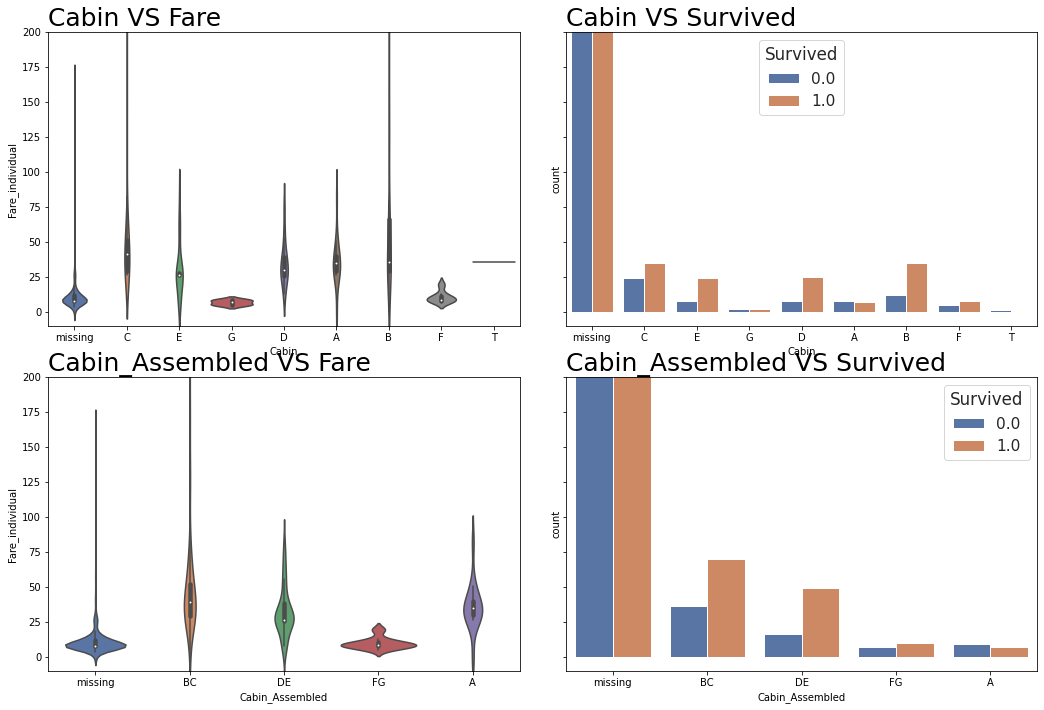

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharey=True)
df_train['Age_cat'] = pd.qcut(df_train.Age, 5, precision=2)


fig.tight_layout(pad=3.0)

sns.set(font_scale=1.4)
sns.set_style('ticks')

sns.violinplot(data=df_train, x='Cabin', y='Fare_individual', ax=ax[0,0])
ax[0,0].set_title('Cabin VS Fare', size=25, loc='Left')
ax[0,0].set_ylim([-10,200])

sns.countplot(data=df_train, x='Cabin', hue='Survived', ax=ax[0,1])
ax[0,1].set_title('Cabin VS Survived', size=25, loc='Left')

sns.violinplot(data=df_train, x='Cabin_Assembled', y='Fare_individual', ax=ax[1,0])
ax[1,0].set_title('Cabin_Assembled VS Fare', size=25, loc='Left')

sns.countplot(data=df_train, x='Cabin_Assembled', hue='Survived', ax=ax[1,1])
ax[1,1].set_title('Cabin_Assembled VS Survived', size=25, loc='Left')


# I want to assign Age based on Title and Pclass
- Let's analyse each Title based on pClass

# comment:
- There is still high variance in imputing Age (e.g. Mr. title has a long range of values). This might impute the wrong age

In [18]:
DF_train = df_train.copy()

for title in DF_train.Title.unique():

    DF_train[title]=DF_train['Title'].copy()
    DF_train[title] = DF_train[title].map({title:title})

<AxesSubplot:xlabel='Master.', ylabel='Age'>

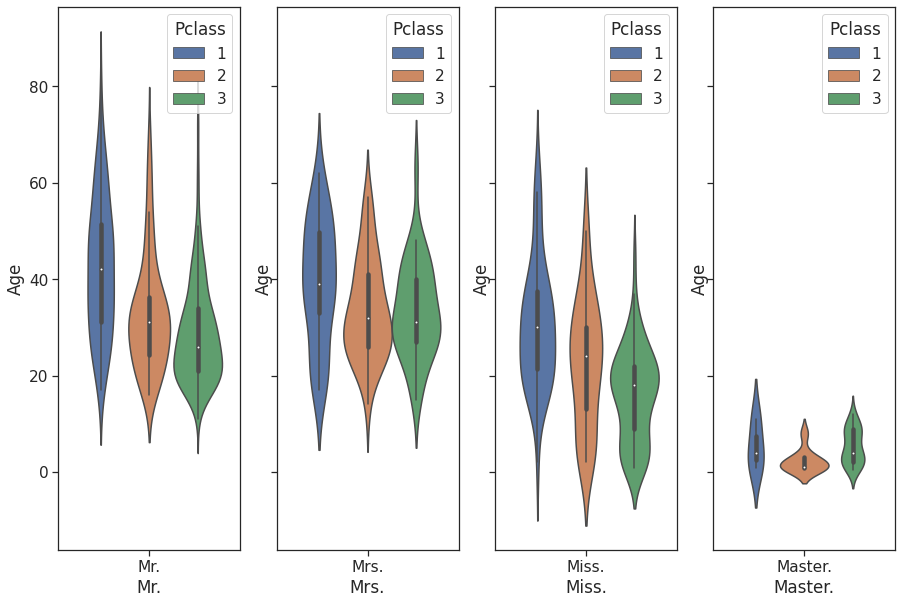

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(15,10), sharey=True)
#DF_train['Fare_cat'] = pd.qcut(df_full.Fare, 5, precision=2)

sns.violinplot(data=DF_train, x='Mr.', y='Age', hue= 'Pclass', ax=ax[0])

sns.violinplot(data=DF_train, x='Mrs.', y='Age', hue= 'Pclass', ax=ax[1])

sns.violinplot(data=DF_train, x='Miss.', y='Age', hue= 'Pclass', ax=ax[2])

sns.violinplot(data=DF_train, x='Master.', y='Age', hue= 'Pclass', ax=ax[3])


In [20]:
def impute_Age(df_train):
    age_impute_series = df_train.groupby(['Title', 'Pclass']).Age.transform('median')
    df_train.Age.fillna(age_impute_series, inplace=True)
    return df_train


df_train = impute_Age(df_train)
df_test = impute_Age(df_test)


print('This list shows the difference between the real age values and the logic used to impute the nulla values')
age_impute_series = df_train.groupby(['Title', 'Pclass']).Age.transform('median')
for i in range(len(df_train)):
    print([(age_impute_series[i],df_train['Age'][i])])

This list shows the difference between the real age values and the logic used to impute the nulla values
[(26.0, 22.0)]
[(39.0, 38.0)]
[(18.0, 26.0)]
[(39.0, 35.0)]
[(26.0, 35.0)]
[(26.0, 26.0)]
[(42.0, 54.0)]
[(4.0, 2.0)]
[(31.0, 27.0)]
[(32.0, 14.0)]
[(18.0, 4.0)]
[(30.0, 58.0)]
[(26.0, 20.0)]
[(26.0, 39.0)]
[(18.0, 14.0)]
[(32.0, 55.0)]
[(4.0, 2.0)]
[(31.0, 31.0)]
[(31.0, 31.0)]
[(31.0, 31.0)]
[(31.0, 35.0)]
[(31.0, 34.0)]
[(18.0, 15.0)]
[(42.0, 28.0)]
[(18.0, 8.0)]
[(31.0, 38.0)]
[(26.0, 26.0)]
[(42.0, 19.0)]
[(18.0, 18.0)]
[(26.0, 26.0)]
[(42.0, 40.0)]
[(39.0, 39.0)]
[(18.0, 18.0)]
[(31.0, 66.0)]
[(42.0, 28.0)]
[(42.0, 42.0)]
[(26.0, 26.0)]
[(26.0, 21.0)]
[(18.0, 18.0)]
[(18.0, 14.0)]
[(31.0, 40.0)]
[(32.0, 27.0)]
[(26.0, 26.0)]
[(24.0, 3.0)]
[(18.0, 19.0)]
[(26.0, 26.0)]
[(26.0, 26.0)]
[(18.0, 18.0)]
[(26.0, 26.0)]
[(31.0, 18.0)]
[(4.0, 7.0)]
[(26.0, 21.0)]
[(39.0, 49.0)]
[(32.0, 29.0)]
[(42.0, 65.0)]
[(42.0, 42.0)]
[(24.0, 21.0)]
[(26.0, 28.5)]
[(24.0, 5.0)]
[(4.0, 11.0)]
[(26.0

In [21]:

#plt.figure(figsize=(15, 8))
#sns.violinplot(data=df_train, x='Mr', y='Age', hue='Pclass') #hue='Sex'
#plt.show()

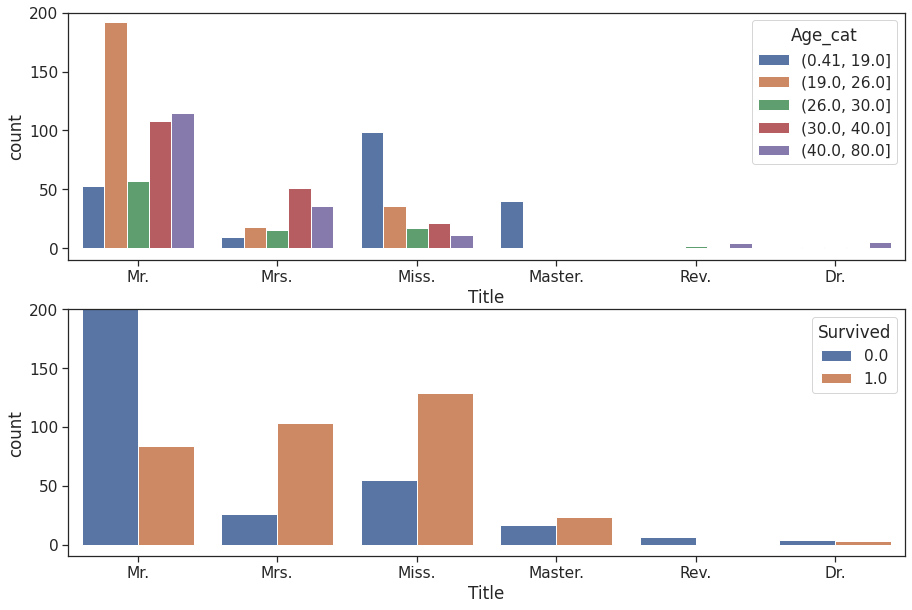

In [22]:
df_train['Fare_cat'] = pd.qcut(df_train.Fare, 5, precision=2)

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharey=True)
df_train['Age_cat'] = pd.qcut(df_train.Age, 5, precision=2)


sns.countplot(data=df_train, x='Title', hue='Age_cat', ax=ax[0])
ax[0].set_ylim([-10,1000])

sns.countplot(data=df_train, x='Title', hue='Survived', ax=ax[1])
ax[1].set_ylim([-10,200])


plt.show()

df_train.isna().sum()


In [23]:
df_test.isna().sum()


PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  1
Cabin                 0
Embarked              0
Ticket_frequency      0
Fare_individual       1
Title                 0
Cabin_Assembled       0
Ticket_assembled      0
dtype: int64

# Let's impute missing values for Fare and Embarked features

In [24]:
df_train.Embarked.fillna('S',inplace=True)
Fare_impute_series = df_test.groupby(['Pclass']).Fare.transform('median')
df_test.Fare.fillna(Fare_impute_series, inplace=True)

(-10.0, 100.0)

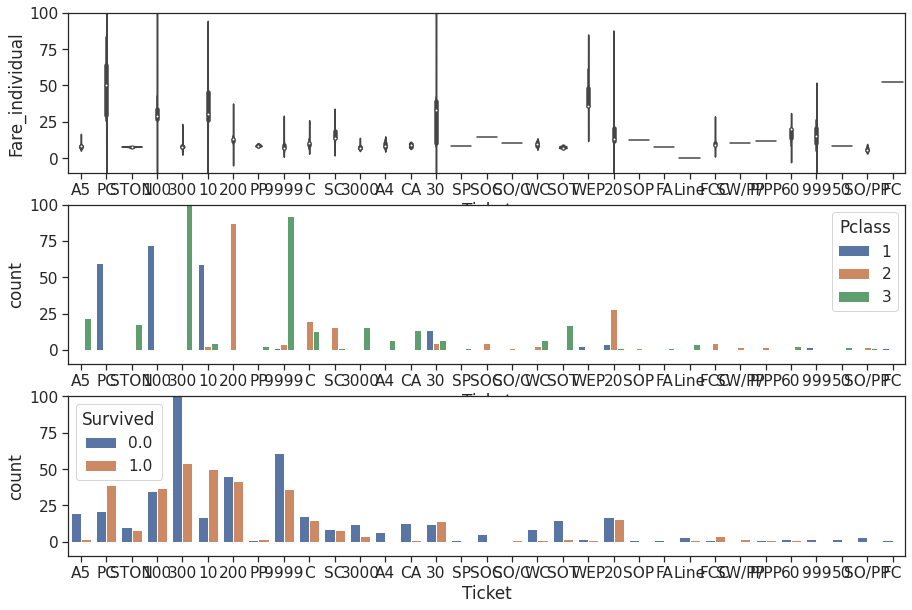

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(15,10), sharey=True)

sns.countplot(data=df_train, x='Ticket',hue='Pclass', ax=ax[1])
ax[0].set_ylim([-10,1000])

sns.violinplot(data=df_train, x='Ticket', y='Fare_individual', ax=ax[0])
ax[1].set_ylim([-10,250])

sns.countplot(data=df_train, x='Ticket', hue='Survived', ax=ax[2])
ax[0].set_ylim([-10,100])

(-10.0, 100.0)

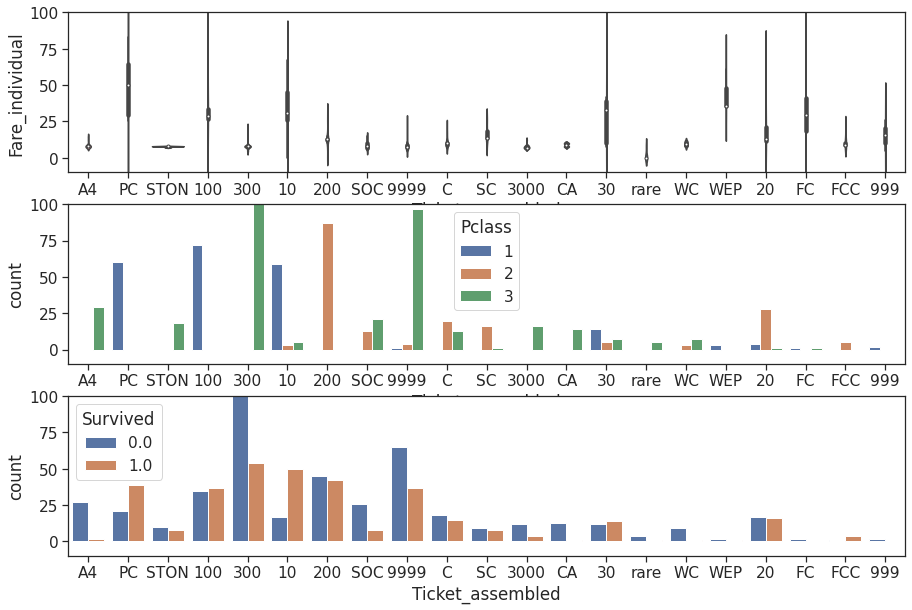

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(15,10), sharey=True)

sns.countplot(data=df_train, x='Ticket_assembled',hue='Pclass', ax=ax[1])
ax[0].set_ylim([-10,1000])

sns.violinplot(data=df_train, x='Ticket_assembled', y='Fare_individual', ax=ax[0])
ax[1].set_ylim([-10,250])

sns.countplot(data=df_train, x='Ticket_assembled', hue='Survived', ax=ax[2])
ax[0].set_ylim([-10,100])

In [27]:
df_train['Family'] = df_train['SibSp'] + df_train['Parch']

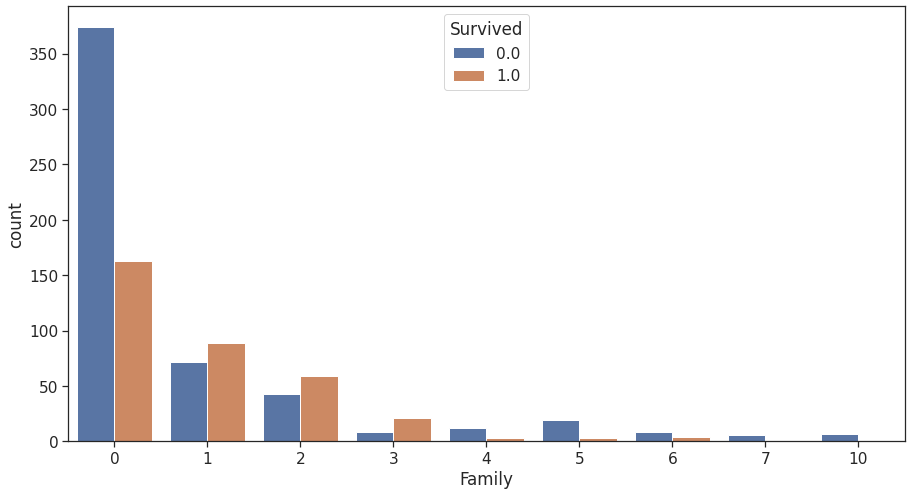

In [28]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df_train, x='Family', hue='Survived') #hue='Sex'
plt.show()


In [29]:
def feature_creator(test, train):
    
    df_train =train.copy()
    df_test = test.copy()


# CREATE TICKET FREQUENCY AND FARE_INDIVIDUAL FOR BOTH TRAINING AND TEST SET
    df_train['Ticket_frequency'] = df_train.Ticket.map(df_train.Ticket.value_counts())
    df_train['Fare_individual']= df_train['Fare'] / df_train['Ticket_frequency']

    df_test['Ticket_frequency'] = df_test.Ticket.map(df_test.Ticket.value_counts())
    df_test['Fare_individual']= df_test['Fare'] / df_test['Ticket_frequency']

    df_full = pd.concat([df_train,df_test]).reset_index(drop=True)



# CREATE TITLE FEATURE FOR BOTH TEST AND TRAINING SET    
    df_full['Title']= np.nan
    df_full['Title'] = df_full.Name.str.extract(pat='([a-zA-Z]+\.)')
    
    for i in range(len(df_full)):
        if df_full['Title'][i] == 'Don.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Mme.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Ms.':
            df_full.Title[i] = 'Miss.'
        elif df_full.Title[i] == 'Major.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Lady.':
            df_full.Title[i] = 'Miss.'
        elif df_full.Title[i] == 'Sir.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Mlle.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Col.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Capt.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Countess.':
            df_full.Title[i] = 'Mrs.'
        elif df_full.Title[i] == 'Jonkheer.':
            df_full.Title[i] = 'Mr.'
        elif df_full.Title[i] == 'Dona.':
            df_full.Title[i] = 'Mrs.'


#CREATE FAMILIZE SIZE FEATURE
    df_full['Family_size']= df_full['SibSp'] + df_full['Parch']
    df_full = df_full.replace({'Family_size' : {0:'No_familly', 1: 'Small_family', 2: 'Small_family',3: 'Small_family',
                                      4: 'Large_family', 5: 'Large_family',6: 'Large_family',7: 'Large_family',
                                     10: 'Large_family',}})
                    

# CREATE CABIN FEATURE FOR BOTH TEST AND TRAINING SET
    df_full['Cabin'] = df_full['Cabin'].astype(str).str[0]
    df_full = df_full.replace({'Cabin': 'n'}, {'Cabin': 'missing'}, regex=True)
    df_full['Cabin_Assembled'] = df_full['Cabin']
    df_full = df_full.replace({'Cabin_Assembled' : {'B': 'BC', 'C': 'BC', 'D': 'DE', 'E':'DE', 'F': 'FG', 'G':'FG', 'T':'A'}})

    
# CREATE TICKET FEATURE FOR BOTH TEST AND TRAINING SET

    for i in range(len(df_full)):

        if df_full['Ticket'][i][:5]=='A./5.':
            df_full['Ticket'][i] = 'A5'

        elif df_full['Ticket'][i][:8]=='S.C./A.4.':
            df_full['Ticket'][i] = 'SC/A4'

        elif df_full['Ticket'][i][:4]=='S.P.':
            df_full['Ticket'][i] = 'SP'

        elif df_full['Ticket'][i][:4]=='A.5.':
            df_full['Ticket'][i] = 'A5'

        elif df_full['Ticket'][i][:3]=='A/S':
            df_full['Ticket'][i] = 'A5'

        elif df_full['Ticket'][i][:2]=='CA':
            df_full['Ticket'][i] = 'CA'

        elif df_full['Ticket'][i][:6]=='S.O.C.':
            df_full['Ticket'][i] = 'SOC'

        elif df_full['Ticket'][i][:4]=='SO/C':
            df_full['Ticket'][i] = 'SO/C'

        elif df_full['Ticket'][i][:3]=='A4.':
            df_full['Ticket'][i] = 'A4'

        elif df_full['Ticket'][i][:4]=='LINE':
            df_full['Ticket'][i] = 'Line'

        elif df_full['Ticket'][i][:2]=='PP':
            df_full['Ticket'][i] = 'PP'

        elif df_full['Ticket'][i][:6]=='F.C.C.':
            df_full['Ticket'][i] = 'FCC'

        elif df_full['Ticket'][i][:3]=='W/C':
            df_full['Ticket'][i] = 'WC'

        elif df_full['Ticket'][i][:3]=='SW/PP':
            df_full['Ticket'][i] = 'SW/PP'

        elif df_full['Ticket'][i][:3]=='CA':
            df_full['Ticket'][i] = 'CA'

        elif len(df_full['Ticket'][i])==6 and df_full['Ticket'][i][0]=='3':
            
            #select_ticket_3.append(i)
            df_full['Ticket'][i] = '300'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][0]=='5':
            #select_ticket_3.append(i)
            df_full['Ticket'][i] = '50'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][0]=='6':
            #select_ticket_3.append(i)
            df_full['Ticket'][i] = '60'


        elif len(df_full['Ticket'][i])==6 and df_full['Ticket'][i][0]=='3':
            #select_ticket_3.append(i)
            df_full['Ticket'][i] = '300'


        elif len(df_full['Ticket'][i])==7 and df_full['Ticket'][i][0]=='3':
            df_full['Ticket'][i] = '3000'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='1':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='2':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='3':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='4':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='5':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='6':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='8':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='9':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==3 and df_full['Ticket'][i][0]=='6':
            df_full['Ticket'][i] = '999'


        elif len(df_full['Ticket'][i])==4 and df_full['Ticket'][i][0]=='7':
            df_full['Ticket'][i] = '9999'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][:2]=='14':
            df_full['Ticket'][i] = '10'

        elif df_full['Ticket'][i][:3]=='A/5':
            df_full['Ticket'][i] = 'A5'

        elif df_full['Ticket'][i][:3]=='A/4':
            df_full['Ticket'][i] = 'A4'

        elif df_full['Ticket'][i][:2]=='CA.':
            df_full['Ticket'][i] = 'CA'

        elif df_full['Ticket'][i][:2]=='SP':
            df_full['Ticket'][i] = 'SP'

        elif df_full['Ticket'][i][:5]=='W./C.':
            df_full['Ticket'][i] = 'WC'

        elif df_full['Ticket'][i][:5]=='SOTON':
            df_full['Ticket'][i] = 'SOT'

        elif df_full['Ticket'][i][0]=='C':
            df_full['Ticket'][i] = 'C'

        elif df_full['Ticket'][i][:4]=='STON':
            df_full['Ticket'][i] = 'STON'

        elif df_full['Ticket'][i][:2]=='PC':
            df_full['Ticket'][i] = 'PC'

        elif len(df_full['Ticket'][i])==6 and df_full['Ticket'][i][:1]=='1':
            df_full['Ticket'][i] = '100'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][:1]=='3':
            df_full['Ticket'][i] = '30'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][:1]=='1':
            df_full['Ticket'][i] = '10'

        elif len(df_full['Ticket'][i])==5 and df_full['Ticket'][i][:1]=='2':
            df_full['Ticket'][i] = '20'

        elif len(df_full['Ticket'][i])==6 and df_full['Ticket'][i][:1]=='2':
            df_full['Ticket'][i] = '200'

        elif df_full['Ticket'][i][:3]=='C.A':
            df_full['Ticket'][i] = 'CA'

        elif df_full['Ticket'][i][:4]=='S0/C':
            df_full['Ticket'][i] = 'SO/C'

        elif df_full['Ticket'][i][:10]=='C.A./SOTON':
            df_full['Ticket'][i] = 'CA/SOT'

        elif df_full['Ticket'][i][:4]=='P/PP':
            df_full['Ticket'][i] = 'P/PP'

        elif df_full['Ticket'][i][:4]=='SC/PARIS':
            df_full['Ticket'][i] = 'SC/PAR'

        elif df_full['Ticket'][i][:8]=='S.O/P.P.':
            df_full['Ticket'][i] = 'SO/PP'

        elif df_full['Ticket'][i][:6]=='C.A. 3':
            df_full['Ticket'][i] = 'CA'

        elif df_full['Ticket'][i][:7]=='C.A. 25':
            df_full['Ticket'][i] = 'CA'

        elif df_full['Ticket'][i][:2]=='SC':
            df_full['Ticket'][i] = 'SC'

        elif df_full['Ticket'][i][:4]=='S.C.':
            df_full['Ticket'][i] = 'SC'

        elif df_full['Ticket'][i][:6]=='W.E.P.':
            df_full['Ticket'][i] = 'WEP'

        elif df_full['Ticket'][i][:7]=='S.W./PP':
            df_full['Ticket'][i] = 'SW/PP'

        elif df_full['Ticket'][i][:7]=='SW/PP':
            df_full['Ticket'][i] = 'SW/PP'  

        elif df_full['Ticket'][i][:4]=='F.C.':
            df_full['Ticket'][i] = 'FC'

        elif df_full['Ticket'][i][:9]== "S.O./P.P.":
            df_full['Ticket'][i] = 'SO/PP'

        elif df_full['Ticket'][i][:6]== "S.O.P.":
            df_full['Ticket'][i] = 'SOP'

        elif df_full['Ticket'][i][:5]== "SW/PP":
            df_full['Ticket'][i] = 'SW/PP'

        elif df_full['Ticket'][i][:2]== "Fa":
            df_full['Ticket'][i] = 'FA'

        elif df_full['Ticket'][i][:4]== "WE/P":
            df_full['Ticket'][i] = 'WEP'

        elif df_full['Ticket'][i][:4]== "AQ/4":
            df_full['Ticket'][i] = '9999'

        elif df_full['Ticket'][i][:5]== "A. 2.":
            df_full['Ticket'][i] = '30000'

        elif df_full['Ticket'][i][:2]== "LP":
            df_full['Ticket'][i] = '9999'

        elif df_full['Ticket'][i][:4]== "AQ/3":
            df_full['Ticket'][i] = '30000'


# CREATE TICKET_ASSEMBLED FEATURE FOR BOTH TEST AND TRAINING SET
    df_full['Ticket_assembled'] = df_full['Ticket']
    df_full.Ticket_assembled.replace(['SO/C','SOP','A5', 'SO/PP','SW/PP', 'P/PP','SOT','SP','Line', '60','50','FA','PP'],
                                      ['SOC','SOC','A4','SOC', 'SOC','SOC','SOC', 'rare', 'rare', '9999','9999','FC','SOC'], 
                                      inplace=True)

    df_train=df_full[:891]
    df_test=df_full[891:]
    

# IMPUTE MISSING VALUES FOR AGE BASED ON TITLE AND CLASS FEAUTURE
    age_impute_series = df_train.groupby(['Title', 'Pclass']).Age.transform('median')
    df_train.Age.fillna(age_impute_series, inplace=True)
    
    age_impute_series = df_test.groupby(['Title', 'Pclass']).Age.transform('median')
    df_test.Age.fillna(age_impute_series, inplace=True)

# CREATE CATEGORIZED AGE AND FARE FEATURE    
    df_train['Fare_cat'] = pd.qcut(df_train.Fare_individual, 5, precision=2)
    df_train['Age_cat'] = pd.qcut(df_train.Age, 5, precision=2)
    df_test['Fare_cat'] = pd.qcut(df_test.Fare_individual, 5, precision=2)
    df_test['Age_cat'] = pd.qcut(df_test.Age, 5, precision=2)    

# FILL NAN VALUES FOR FARE FEAUTURE IN TEST SET AND EMBARKED FEATURE FOR TRAINING SET    
    df_train.Embarked.fillna('S',inplace=True)
    Fare_impute_series = df_test.groupby(['Pclass']).Fare.transform('median')
    df_test.Fare.fillna(Fare_impute_series, inplace=True)
    Fare_impute_series = df_test.groupby(['Pclass']).Fare_individual.transform('median')
    df_test.Fare_individual.fillna(Fare_impute_series, inplace=True)
    
    
# ENCODE CATEGORICAL FEATURE 

    features_to_encode = ['Sex','Ticket', 'Cabin' , 'Cabin_Assembled', 'Ticket_assembled',
                          'Title','Fare_cat', 'Age_cat', 'Embarked', 'Family_size']
    df_full = pd.concat([df_train,df_test]).reset_index(drop=True)
    
    for feauture in features_to_encode:
        df_full[feauture]=pd.factorize(df_full[feauture])[0]
    


    df_train=df_full[:891]
    df_test=df_full[891:]
    
    labels= pd.DataFrame(data=df_train['Survived'])
    df_train.drop(['Survived','Name','PassengerId', 'Fare', 'Ticket', 'Cabin', 'Ticket_frequency', 'SibSp', 'Parch'], axis=1, inplace=True)
    df_test.drop(['Survived','Name','PassengerId', 'Fare', 'Ticket', 'Cabin', 'Ticket_frequency', 'SibSp', 'Parch'], axis=1, inplace=True)




    
    return df_test, df_train, labels

In [30]:
df_test, df_train, labels = feature_creator(test, train)

In [31]:
df_train

,Pclass,Sex,Age,Embarked,Fare_individual,Title,Family_size,Cabin_Assembled,Ticket_assembled,Fare_cat,Age_cat
0,3,0,22.0,0,7.2500,0,0,0,0,0,0
1,1,1,38.0,1,71.2833,1,0,1,1,1,1
2,3,1,26.0,0,7.9250,2,1,0,2,2,0
3,1,1,35.0,0,26.5500,1,0,1,3,3,1
4,3,0,35.0,0,8.0500,0,1,0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,13.0000,4,1,0,6,3,4
887,1,1,19.0,0,30.0000,2,1,1,3,1,3
888,3,1,18.0,0,11.7250,2,0,0,15,4,3
889,1,0,26.0,1,30.0000,0,1,1,3,1,0


In [32]:
df_test

,Pclass,Sex,Age,Embarked,Fare_individual,Title,Family_size,Cabin_Assembled,Ticket_assembled,Fare_cat,Age_cat
891,3,0,34.5,2,7.8292,0,1,0,4,5,5
892,3,1,47.0,0,7.0000,1,0,0,4,6,6
893,2,0,62.0,2,9.6875,0,1,0,6,7,6
894,3,0,27.0,0,8.6625,0,1,0,4,5,7
895,3,1,22.0,0,12.2875,1,0,0,11,7,8
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,25.0,0,8.0500,0,1,0,0,5,8
1305,1,1,39.0,1,108.9000,1,1,1,1,9,5
1306,3,0,38.5,0,7.2500,0,1,0,7,6,5
1307,3,0,25.0,0,8.0500,0,1,0,4,5,8


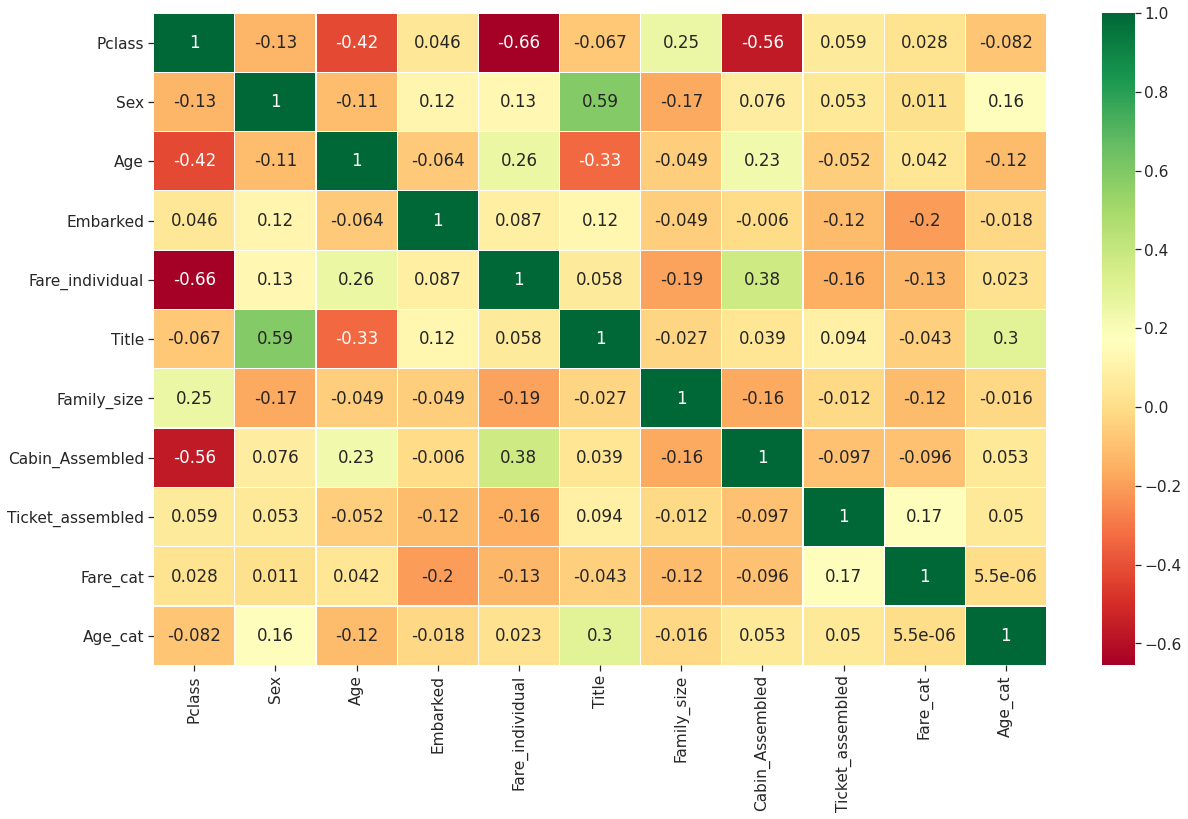

In [34]:
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [35]:
df_train.corr()

,Pclass,Sex,Age,Embarked,Fare_individual,Title,Family_size,Cabin_Assembled,Ticket_assembled,Fare_cat,Age_cat
Pclass,1.000000,-0.131900,-0.418218,0.045702,-0.655559,-0.067312,0.249895,-0.561396,0.059368,0.027695,-0.082091
Sex,-0.131900,1.000000,-0.106072,0.116569,0.128809,0.589938,-0.167282,0.075879,0.053423,0.011310,0.164428
Age,-0.418218,-0.106072,1.000000,-0.064325,0.258066,-0.333740,-0.048571,0.234287,-0.051945,0.041638,-0.118213
Embarked,0.045702,0.116569,-0.064325,1.000000,0.086765,0.122264,-0.048784,-0.005953,-0.117004,-0.202834,-0.017553
Fare_individual,-0.655559,0.128809,0.258066,0.086765,1.000000,0.058171,-0.188731,0.376459,-0.155587,-0.131181,0.022863
Title,-0.067312,0.589938,-0.333740,0.122264,0.058171,1.000000,-0.026941,0.038799,0.093909,-0.042530,0.295119
Family_size,0.249895,-0.167282,-0.048571,-0.048784,-0.188731,-0.026941,1.000000,-0.164834,-0.012055,-0.118221,-0.016374
Cabin_Assembled,-0.561396,0.075879,0.234287,-0.005953,0.376459,0.038799,-0.164834,1.000000,-0.096635,-0.096378,0.052901
Ticket_assembled,0.059368,0.053423,-0.051945,-0.117004,-0.155587,0.093909,-0.012055,-0.096635,1.000000,0.165488,0.049586
Fare_cat,0.027695,0.011310,0.041638,-0.202834,-0.131181,-0.042530,-0.118221,-0.096378,0.165488,1.000000,0.000006


In [36]:
# if we wish to create a transformer which we can grid search in a pipeline, that transformer has to inherit from the 
# BaseEstimator class, we will also make our FeatureEngineering transformer inherit from the TransformerMixin which just 
# provides the functionality of fit_transform() method to our transformer.

class FeatureEngineering(BaseEstimator, TransformerMixin):

    def __init__(self, Fare_individual=True, drop_Embarked= True, drop_Family_size= False,
                 Age=True, drop_Ticket_assembled=False, drop_Cabin_Assembled=False,
                 scaling='StandardScaler', #Get_dummies=True
                ):

           
        self.Fare_individual = Fare_individual
        self.drop_Embarked = drop_Embarked
        self.drop_Family_size = drop_Family_size
        self.Age = Age
        self.drop_Ticket_assembled = drop_Ticket_assembled
        self.drop_Cabin_Assembled = drop_Cabin_Assembled
        self.scaling = scaling
        self.transformer = None
        #self.Get_dummies = Get_dummies


        self.transformer = None
        self.drop_list = []
        self.test = test
        
    def fit(self, X, y=None):
        return self # the fit method usually return self only, if not sure, try fitting a scikit learn estimator/transformer.. 
                    # only the fitted object will be returned, fit() will include code in case of these transformers and
                    # estimators but we do not need to have some fitted variables on our dataset before we go for transform,
                    # or atleast the way i am doing it i don't need to. :) 
    
    def transform(self, X, y=None):
        
        
        if self.Fare_individual:
            X.drop('Fare_cat', axis=1, inplace=True)
        else:
            X.drop('Fare_individual', axis=1, inplace=True)
                                
        
        if self.drop_Embarked:
            X.drop('Embarked', axis=1, inplace=True)
       
        if self.drop_Family_size:
            X.drop('Family_size', axis=1, inplace=True)

        if self.Age:
            X.drop('Age', axis=1, inplace=True)
        else:
            X.drop('Age_cat', axis=1, inplace=True)
            
        if self.drop_Cabin_Assembled:
            X.drop('Cabin_Assembled', axis=1, inplace=True)
            
        if self.drop_Ticket_assembled:
            X.drop('Ticket_assembled', axis=1, inplace=True)
        
        
        features_to_scale = [feature for feature in X.columns if X[feature].nunique() != 2]
        #features_to_hot_encode = [feature for feature in X.columns if X[feature].nunique() < 7]
        
        print(features_to_scale)
        #print(features_to_hot_encode)
        
        # only features with no. of unique values as 2, will one hot encoded features and we do not want to apply Normalization
        # on them(reason explained in a bit)
        
        
        if self.scaling == 'StandardScaler':
            self.transformer = StandardScaler()
            X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
                
        elif self.scaling == 'RobustScaler':
            self.transformer = RobustScaler()
            X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
                
        elif self.scaling == 'MinMaxScaler':
            self.transformer = MinMaxScaler()
            X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
            
        #if self.Get_dummies:
        #    features_to_hot_encode = [feature for feature in X.columns if X[feature].nunique() < 10]
        #    X = pd.get_dummies(X, columns = features_to_hot_encode,
        #                     prefix=features_to_hot_encode)
        #    X = pd.get_dummies(X, columns = features_to_hot_encode,
        #                     prefix=features_to_hot_encode)
            
            
            
        
        
        return X

In [37]:
>>> from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


param_grid_pipeline = {
                       'feature_engineering__Fare_individual':[True, False],
                       'feature_engineering__drop_Embarked':[True, False],
                       'feature_engineering__drop_Family_size':[True, False],
                       'feature_engineering__Age':[True, False],
                       'feature_engineering__drop_Cabin_Assembled':[True, False],
                       'feature_engineering__drop_Ticket_assembled':[True, False],
                       'feature_engineering__scaling':['MinMaxScaler','RobustScaler', 'StandardScaler']
                       #'feature_engineering__Get_dummies':[True]
}     



pipeline_ = Pipeline([('feature_engineering', FeatureEngineering()),
                 ('model', GradientBoostingClassifier())])

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=101)

grid = GridSearchCV(pipeline_, param_grid_pipeline, 
                    cv=cv,
                    scoring=['accuracy','f1'], verbose=2, n_jobs=-1, refit='f1')

grid.fit(df_train.copy(), labels.values.reshape((891,)))

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   35.1s


['Pclass', 'Title', 'Family_size', 'Cabin_Assembled', 'Ticket_assembled', 'Fare_cat', 'Age_cat']


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:   46.5s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=101, test_size=0.25,
            train_size=None),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureEngineering()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'feature_engineering__Age': [True, False],
                         'feature_engineering__Fare_individual': [True, False],
                         'feature_engineering__drop_Cabin_Assembled': [True,
                                                                       False],
                         'feature_engineering__drop_Embarked': [True, False],
                         'feature_engineering__drop_Family_size': [True, False],
                         'feature_engineering__drop_Ticket_assembled': [True,
                                                                       

In [38]:
def results(grid, n=10):
    for index, row in pd.DataFrame(grid.cv_results_)[['params', 
                                                      'mean_test_accuracy']].nlargest(n=n, columns='mean_test_accuracy').iterrows():
        print(f'{row[0]} : {row[1]}', grid.cv_results_['std_test_accuracy'][index], grid.cv_results_['mean_test_f1'][index],  grid.cv_results_['std_test_f1'][index], grid.cv_results_['rank_test_f1'][index], grid.cv_results_['rank_test_accuracy'][index])

In [39]:
pd.DataFrame(grid.cv_results_)['mean_test_accuracy'].isna().sum() # check if error occured while using a feature combination or not.

#pd.DataFrame(grid.cv_results_)['mean_test_score'].isna().sum() # check if error occured while using a feature combination or not.


0

In [40]:
results(grid, n=60)

{'feature_engineering__Age': True, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': True, 'feature_engineering__scaling': 'StandardScaler'} : 0.8349775784753364 0.017344466014182693 0.7734473832536901 0.02816360422205629 5 1
{'feature_engineering__Age': True, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': True, 'feature_engineering__scaling': 'MinMaxScaler'} : 0.8345291479820627 0.017069835256210104 0.772962644936641 0.027913012740632112 6 2
{'feature_engineering__Age': True, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': False, 'feature_engineering__drop_Embarked': True, 

In [41]:
#TEST SIZE = 0.25 {'feature_engineering__Age': True, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': True, 'feature_engineering__scaling': 'StandardScaler'} : 0.8349775784753364 0.017344466014182693 0.7734473832536901 0.02816360422205629 4 1
#TEST SIZE = 0.20 {'feature_engineering__Age': False, 'feature_engineering__Fare_individual': True, 'feature_engineering__drop_Cabin_Assembled': False, 'feature_engineering__drop_Embarked': False, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': False, 'feature_engineering__scaling': 'MinMaxScaler'} : 0.8374301675977653 0.029291009450096824 0.7735268292843795 0.04857177465781662 1 1
#TEST SIZE = 0.15 {'feature_engineering__Age': False, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': False, 'feature_engineering__scaling': 'StandardScaler'} : 0.8373134328358208 0.024250860909361065 0.7738253840202558 0.03255834999166147 1 1
#TEST SIZE = 0.10 {'feature_engineering__Age': True, 'feature_engineering__Fare_individual': True, 'feature_engineering__drop_Cabin_Assembled': False, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': False, 'feature_engineering__scaling': 'MinMaxScaler'} : 0.8299999999999998 0.03686813338452678 0.767488914046449 0.053349588397845725 1 1

In [42]:
#LOGISTICREGRESSION: {'feature_engineering__Age': False, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': False, 'feature_engineering__drop_Family_size': False, 'feature_engineering__drop_Ticket_assembled': True, 'feature_engineering__scaling': 'MinMaxScaler'} : 0.8103383340656581
#DECISIONTREEECLASSIFIER: {'feature_engineering__Age': True, 'feature_engineering__Fare_individual': False, 'feature_engineering__drop_Cabin_Assembled': True, 'feature_engineering__drop_Embarked': True, 'feature_engineering__drop_Family_size': True, 'feature_engineering__drop_Ticket_assembled': True, 'feature_engineering__scaling': 'StandardScaler'} : 0.8182286108844391

In [43]:
#0.25
fe_25 = FeatureEngineering(Age= True, Fare_individual= False, drop_Cabin_Assembled=True,
                           drop_Embarked= True, drop_Family_size= False, 
                           drop_Ticket_assembled= True, scaling= 'StandardScaler')

#0.20
fe_20 = FeatureEngineering(Age= False, Fare_individual= True, drop_Cabin_Assembled=False,
                           drop_Embarked= False, drop_Family_size= False, drop_Ticket_assembled= False,
                           scaling= 'MinMaxScaler')

#0.15
fe_15 = FeatureEngineering(Age= False, Fare_individual= False, drop_Cabin_Assembled= True,
                        drop_Embarked= True, drop_Family_size= False, drop_Ticket_assembled= False,
                        scaling= 'StandardScaler')
#0.10
fe_10= FeatureEngineering( Age= True, Fare_individual= True, drop_Cabin_Assembled= False,
                        drop_Embarked= True, drop_Family_size= False, drop_Ticket_assembled= False,
                        scaling= 'MinMaxScaler')

df_train_fe25 = fe_25.fit_transform(df_train.copy())
df_test_fe25 = fe_25.fit_transform(df_test.copy())

df_train_fe20 = fe_20.fit_transform(df_train.copy())
df_test_fe20 = fe_20.fit_transform(df_test.copy())

df_train_fe15 = fe_15.fit_transform(df_train.copy())
df_test_fe15 = fe_15.fit_transform(df_test.copy())

df_train_fe10 = fe_10.fit_transform(df_train.copy())
df_test_fe10 = fe_10.fit_transform(df_test.copy())

# 0.8148201619484026 03_03_2021

['Pclass', 'Title', 'Family_size', 'Fare_cat', 'Age_cat']
['Pclass', 'Title', 'Family_size', 'Fare_cat', 'Age_cat']
['Pclass', 'Age', 'Embarked', 'Fare_individual', 'Title', 'Family_size', 'Cabin_Assembled', 'Ticket_assembled']
['Pclass', 'Age', 'Embarked', 'Fare_individual', 'Title', 'Family_size', 'Cabin_Assembled', 'Ticket_assembled']
['Pclass', 'Age', 'Title', 'Family_size', 'Ticket_assembled', 'Fare_cat']
['Pclass', 'Age', 'Title', 'Family_size', 'Ticket_assembled', 'Fare_cat']
['Pclass', 'Fare_individual', 'Title', 'Family_size', 'Cabin_Assembled', 'Ticket_assembled', 'Age_cat']
['Pclass', 'Fare_individual', 'Title', 'Family_size', 'Cabin_Assembled', 'Ticket_assembled', 'Age_cat']


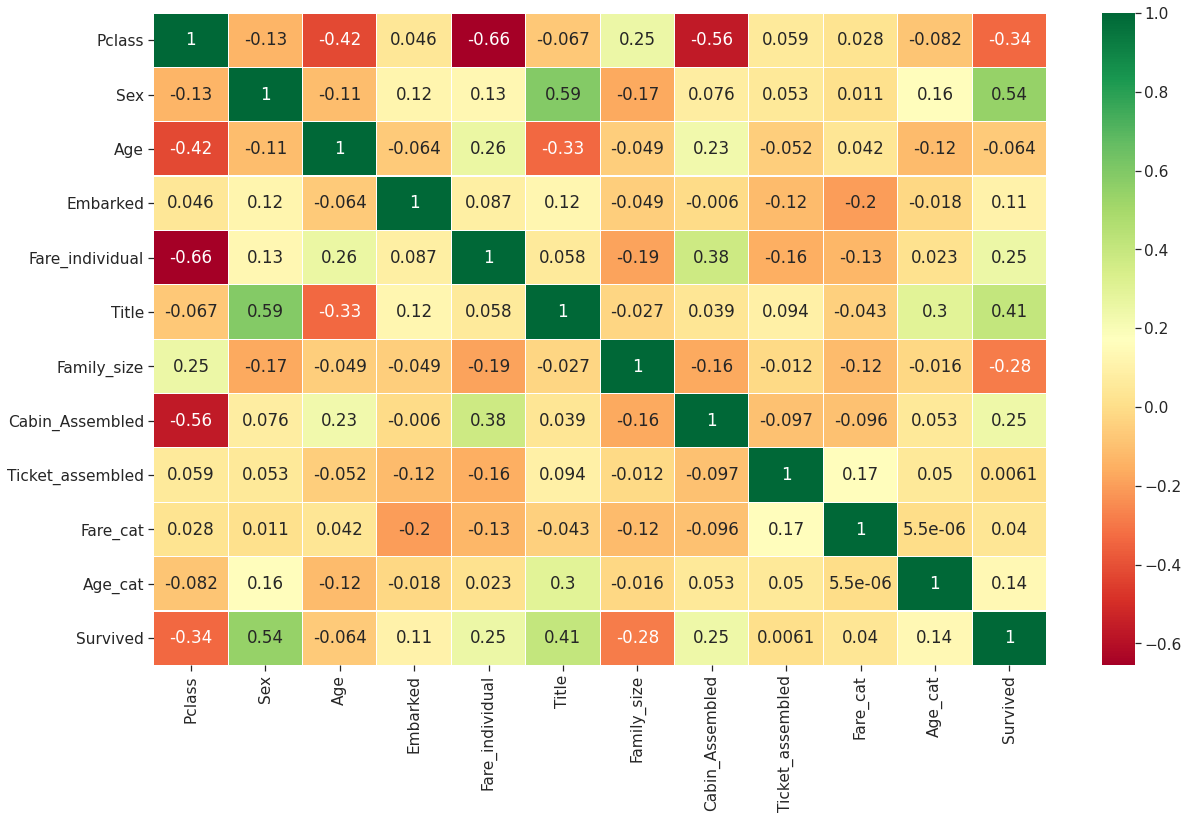

In [47]:
def correlation_matrix(dataset_, labels):
    dataset = dataset_.copy()
    dataset['Survived'] = labels
    
    sns.heatmap(dataset.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
    fig=plt.gcf()
    fig.set_size_inches(20,12)
    plt.show()

correlation_matrix(df_train, labels)

In [36]:
import warnings; warnings.simplefilter('ignore')

kfold = StratifiedKFold(n_splits = 10)
param= {}
param['min_child_weight']=1
xgb = XGBClassifier(min_child_weight=1)
param_grid = {
        'min_child_weight': [5]
}


print('\n')
cv = cross_val_score(xgb,df_train_fe10,labels,cv=kfold)
print(cv)
print(cv.mean())
print(cv.std())
print("_"*30)

clf_xgb = GridSearchCV(xgb,param_grid = param_grid, cv=kfold, 
                       scoring=['accuracy','f1'], refit='accuracy')
best_clf_xgb = clf_xgb.fit(df_train_fe10,labels)
results = best_clf_xgb.cv_results_
results





[07:44:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:44:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:44:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:44:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

{'mean_fit_time': array([0.32064924]),
 'std_fit_time': array([0.5134811]),
 'mean_score_time': array([0.02684214]),
 'std_score_time': array([0.03420879]),
 'param_min_child_weight': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 5}],
 'split0_test_accuracy': array([0.82222222]),
 'split1_test_accuracy': array([0.85393258]),
 'split2_test_accuracy': array([0.78651685]),
 'split3_test_accuracy': array([0.82022472]),
 'split4_test_accuracy': array([0.87640449]),
 'split5_test_accuracy': array([0.86516854]),
 'split6_test_accuracy': array([0.82022472]),
 'split7_test_accuracy': array([0.84269663]),
 'split8_test_accuracy': array([0.83146067]),
 'split9_test_accuracy': array([0.76404494]),
 'mean_test_accuracy': array([0.82828964]),
 'std_test_accuracy': array([0.03254154]),
 'rank_test_accuracy': array([1], dtype=int32),
 'split0_test_f1': array([0.75757576]),
 'split1_test_f1': array([0.8]),
 'split

In [37]:
def plot_parameter_analysis(results, parameter_name):
    
    str1='param_'
    indexes= []
    
    for i in range(len(parameter_name)):
        string=str1+parameter_name[i]
        indexes.append(np.array(results[string].data))
    
    Table=pd.DataFrame(index=indexes)
    
    Table['mean_test_accuracy'] = results['mean_test_accuracy']
    Table['std_test_accuracy'] = results['std_test_accuracy']
    Table['mean_test_f1'] = results['mean_test_f1']
    Table['std_test_f1'] = results['std_test_f1']
    Table['Lower_bound'] = results['mean_test_accuracy'] - results['std_test_accuracy']
    Table['rank_accuracy'] = results['rank_test_accuracy']
    Table['rank_f1'] = results['rank_test_f1']
    
    Table = Table.sort_values(by='rank_f1', ascending=True)

    return Table    
#300	0.0575	0	

#n.estimators225	learningrate0.200000	0.840662	0.041218	0.782344	0.057074	0.799443	1	1

        'min_child_weight': [1],
        'learning_rate': np.linspace(0.01,0.2,8).tolist(), #[0.089]
        'n_estimators' : np.arange(25,800,100).tolist(),
        'gamma': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.4],
        'max_depth': [4],
        'nthread' : np.arange(1,9,1).tolist()}
        
n_estimators600	learning_rate0.150	min_child_weight1	gamma1	subsample0.8	colsample_bytree0.2	max_depth6	0.846242	0.033713	0.791727	0.050354	0.812529	1	1

575	0.16	0.849613	0.030198	0.796432	0.046805	0.819415	1	1

In [47]:
##### np.arange(0,12,2).tolist()
#np.linspace(0.05,0.1,4).tolist()
kfold = StratifiedKFold(n_splits = 40)
scoring = {'score': make_scorer(accuracy_score)}    
xgb = XGBClassifier()
param_grid = {
        'min_child_weight': [1],
        'learning_rate': [0.16,], #[0.089]
        'n_estimators' : [575],
        'gamma': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.2],
        'max_depth': [6],
        'nthread' : [1]}

clf_xgb = GridSearchCV(xgb,param_grid = param_grid, cv=kfold, scoring=['accuracy','f1'],refit='f1')
best_clf_xgb = clf_xgb.fit(df_train_fe10,labels)
results = best_clf_xgb.cv_results_
plot_parameter_analysis(results, parameter_name=['n_estimators','learning_rate'])

[08:06:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:06:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,,mean_test_accuracy,std_test_accuracy,mean_test_f1,std_test_f1,Lower_bound,rank_accuracy,rank_f1
575,0.16,0.843034,0.075737,0.787741,0.105927,0.767297,1,1


In [45]:
results

{'mean_fit_time': array([0.13026944]),
 'std_fit_time': array([0.0232915]),
 'mean_score_time': array([0.00267889]),
 'std_score_time': array([0.00051287]),
 'param_colsample_bytree': masked_array(data=[0.2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[575],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_nthread': masked_array(data=[1],
              mask=[False],
        fill

In [ ]:
pd.set_option('display.max_rows', 100)
plot_parameter_analysis(results, parameter_name=['n_estimators','learning_rate','min_child_weight',
                                                 'gamma', 'subsample','colsample_bytree','max_depth'])

In [ ]:
plot_parameter_analysis(results, parameter_name_='n_estimators', range_parameters=(0,1000), scoring=['accuracy','f1'])            

In [54]:
best_clf_xgb 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     mi...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [55]:
from sklearn.model_selection import cross_val_score, learning_curve

In [56]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=10,
                        n_jobs=-1, train_sizes=np.linspace(0.7, 1, 6)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

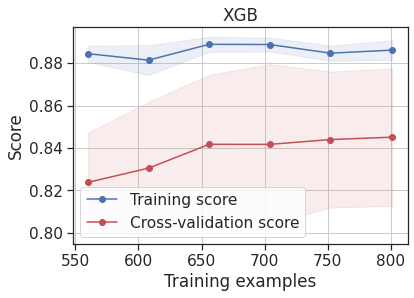

In [57]:
#g = plot_learning_curve(best_clf_rf.best_estimator_,"RF mearning curves",traindf,labels,cv=kfold)
#g = plot_learning_curve(best_clf_svc.best_estimator_,"SVC learning curves",traindf,y_train,cv=kfold)
#g = plot_learning_curve(best_clf_lr.best_estimator_,"Logistic Regression",traindf,labels,cv=kfold)
g = plot_learning_curve(best_clf_xgb.best_estimator_,"XGB",df_train_fe10,labels,cv=kfold)

In [62]:
best_clf_xgb

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     mi...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [59]:
Y_pred_rf = best_clf_xgb .predict(df_test_fe10)
#Y_pred_rf = best_clf_lr .predict(testdf)
Y_pred_rf = [int(Y_pred_rf[i]) for i in range(len(Y_pred_rf))]
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred_rf})

In [60]:
submission.to_csv('./submission.csv',index=False)


In [61]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
             param_grid={'colsample_bytree': [0.2], 'gamma': [1],
                         'learning_rate': [0.16], 'max_depth': [6],
                         'min_child_weight': [1], 'n_estimators': [575],
                         'nthread': [1], 'subsample': [0.8]},


In [ ]:
{'max_iter' : [3],
              'penalty' : ['l2'],
              'C' : [0.5],
              'solver' : ['liblinear']}

In [ ]:
tuned_gb = LogisticRegression(max_iter =[3],
              penalty = ['l2'],
              C = [0.5],
              solver = ['liblinear'])

In [63]:

tuned_gb = XGBClassifier(learning_rate=0.16,
                                        n_estimators=575,
                                       max_depth=6,
                                       min_child_weight=1,
                                       gamma=1,
                                       subsample=0.8,
                                       colsample_bytree=0.2,
                                       nthread=1,
                                       )
#BEST SO FAR IN CROSS VALIDATION                                     

In [64]:

tuned_gb = XGBClassifier(learning_rate=0.15,
                                        n_estimators=600,
                                       max_depth=4,
                                       min_child_weight=4,
                                       gamma=1,
                                       subsample=0.8,
                                       colsample_bytree=0.4,
                                       #objective= 'binary:logistic',# 'multi:softmax'
                                       nthread=4,
                                       )


In [71]:
def evaluateModel_K_Cross_Validation(model, x_training, y_training, numero_folds):

    """
    This method performs the Stratified K cross validation and produce a table filled with scores of metrics
    for both training and validation sets.

    Args:
        model(estimator): tuned model
        x_training(array-like of shape (n_samples, n_features): Training vector, where n_samples is the number of
                                                                 samples and n_features is the number of features.
        y_training(array-like of shape (n_samples, n_output): Target relative to X for classification
        numero_folds(int): to specify the number of folds in a (Stratified)KFold

    """

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    current_date = datetime.today().strftime('%Y-%m-%d')
    print("Local current time :", current_date, ' ', current_time)
    print()
    model_name = type(model).__name__
    print('MODELLO: ' + model_name)
    print('RIEPILOGO PARAMETRI: ' + str(model))
    print()

    cv = StratifiedKFold(n_splits=numero_folds, shuffle=True, random_state= 0)

    scoring = ['accuracy',
               'neg_mean_absolute_error',
               'neg_mean_squared_error',
               'precision_macro',
               'recall_macro',
               'f1_macro',
               'neg_log_loss']

    scores = cross_validate(model, x_training, y_training,
                            scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)

    print('EVALUATION ON CROSS VALIDATION :')
    print()

    # accuracy scores in each fold
    print('Train Accuracy scores:', scores['train_accuracy'])
    print('Validation Accuracy scores:', scores['test_accuracy'])
    print()

    # tabella con statistiche sulle metriche della cross validation
    t = PrettyTable(['Metrics', 'Training Set', 'Validation Set'])
    t.add_row(['Mean Acc', '%.3f' % (scores['train_accuracy'].mean() * 100),
               '%.3f' % (scores['test_accuracy'].mean() * 100)])
    t.add_row(['Var Acc', '%.3f' % ((scores['train_accuracy'].std()) * 100),
               '%.3f' % (scores['test_accuracy'].std() * 100)])
    t.add_row(['MAE', '%.3f' % (-(scores['train_neg_mean_absolute_error'].mean())),
               '%.3f' % (-(scores['test_neg_mean_absolute_error'].mean()))])
    t.add_row(['MSE', '%.3f' % (-(scores['train_neg_mean_squared_error'].mean())),
               '%.3f' % (-(scores['test_neg_mean_squared_error'].mean()))])
    t.add_row(['Precision', '%.3f' % (scores['train_precision_macro'].mean()),
               '%.3f' % (scores['test_precision_macro'].mean())])
    t.add_row(
        ['Recall', '%.3f' % (scores['train_recall_macro'].mean()), '%.3f' % (scores['test_recall_macro'].mean())])
    t.add_row(['F1_Score', '%.3f' % (scores['train_f1_macro'].mean()), '%.3f' % (scores['test_f1_macro'].mean())])
    t.add_row(['Log Loss', '%.3f' % (-(scores['train_neg_log_loss'].mean())),
               '%.3f' % (-(scores['test_neg_log_loss'].mean()))])

    print(t)

In [72]:
evaluateModel_K_Cross_Validation(model=tuned_gb,
                                 x_training=df_train_fe10,
                                 y_training=labels,
                                 numero_folds = 10)

Local current time : 2021-03-29   10:54:00

MODELLO: XGBClassifier
RIEPILOGO PARAMETRI: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.2, gamma=1, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.16, max_delta_step=None, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=575, n_jobs=None, nthread=1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

EVALUATION ON CROSS VALIDATION :

Train Accuracy scores: [0.88639201 0.88154613 0.88902743 0.88528678 0.88653367 0.88653367
 0.89650873 0.88778055 0.8915212  0.88778055]
Validation Accuracy scores: [0.85555556 0.86516854 0.84269663 0.85393258 0.84269663 0.84269663
 0.79775281 0.

In [ ]:
'''
XLG
1)             param_grid={'colsample_bytree': [0.4], 'gamma': [1],
                         'learning_rate': [0.089], 'max_depth': [4],
                         'min_child_weight': [6], 'n_estimators': [500],
                         'subsample': [0.8]},


#|  Mean Acc |    92.640    |     83.374     |
#|  Var Acc  |    0.002     |     0.267  


2)             param_grid={'colsample_bytree': [0.4], 'gamma': [1],
                         'learning_rate': [0.089], 'max_depth': [4],
                         'min_child_weight': [6], 'n_estimators': [500],
                         'subsample': [0.8]},
                         
|  Mean Acc |    90.088    |     83.717     |
|  Var Acc  |    0.002     |     0.231  



In [5]:
# VAR TO STD
print(np.sqrt((0.267/100))*100)
# STD TO VAR
((2.336/100)**2)*100

5.167204273105526


0.05456895999999999

In [75]:
best_clf_xgb

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     mi...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [77]:
Y_pred_rf = best_clf_xgb.predict(df_test_fe10)
#Y_pred_rf = best_clf_lr .predict(testdf)
Y_pred_rf = [int(Y_pred_rf[i]) for i in range(len(Y_pred_rf))]
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred_rf})

In [78]:
submission.to_csv('./submission.csv',index=False)


In [79]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0



#CONSIDERATIONS

RESULT WAS 0.75. A first warning was given by the learning curve which was not flat. Infact it seems to be very high on the 80-90% training size which is also the size used to cross-validate the training set. Keep in mind this aspect next time.